In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from scipy import signal
import random

import h5py
from IPython.utils import io

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from scipy import signal
import random
import scipy.stats as stats

import h5py
from IPython.utils import io

from joblib import Parallel, delayed
from tqdm import tqdm
import pandas as pd

In [2]:
import sys
sys.path.append('../../../../nadavp/new_trap/Tools/')
sys.path.append('../../../../nadavp/new_trap/Tools/StatFramework/')
import BeadDataFile
from discharge_tools import *

from likelihood_calculator import likelihood_analyser
from likelihood_calculator import GravityFramework
from likelihood_calculator import auxiliary_functions as aux
gfw = GravityFramework.GravityFramework()

sys.path.append('/home/analysis_user/New_trap_code/SensitivityFramework/')
from signal_model_utilities_v3b import *

OSError: /data/old_trap_processed/sensitivities/decca1_limits.txt not found.

In [ ]:
%matplotlib widget

In [3]:
%reload_ext autoreload
%autoreload 2

### Setting up parameters

In [4]:
df = pd.read_pickle("/data/new_trap_processed/processed_files/20200320/Bead1/Shaking/Shaking378/Shaking3_aux.pkl") #here one could put the respective file name
height_cal = df["z_distance_emp"]
time = df['Time_Epoch']
time -= time[0]

No height data
No cantilever data
Error loading spinning data
No laser power data
No height data
No cantilever data
Error loading spinning data
No laser power data
No height data
No cantilever data
Error loading spinning data
No laser power data


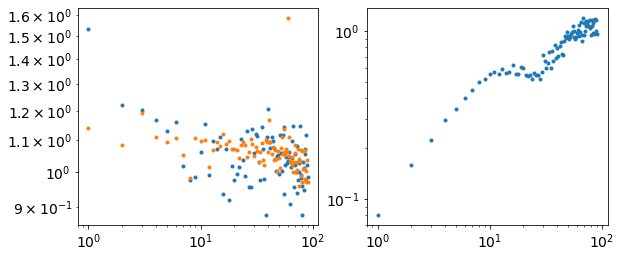

In [6]:
fname = r'/home/data_transfer/data_from_windows/20200320/Bead1/TransFunc/Repeat_TransFunc_20200104/TransFunc_X_m300k_250s_1hz.h5'
tf_x = BeadDataFile.BeadDataFile(fname)
fname = r'/home/data_transfer/data_from_windows/20200320/Bead1/TransFunc/Repeat_TransFunc_20200104/TransFunc_Y_m300k_250s_1hz.h5'
tf_y = BeadDataFile.BeadDataFile(fname)
fname = r'/home/data_transfer/data_from_windows/20200320/Bead1/TransFunc/Repeat_TransFunc_20200104/TransFunc_Z_m300k_250s_1hz.h5'
tf_z = BeadDataFile.BeadDataFile(fname)
gfw.build_transfer_function([tf_x, tf_y, tf_z], base_freq=1, number_of_harmonics=90, scale_freq=71, plot=True)

In [7]:
bdf_discharge = load_dir(dirname='/data/new_trap/20200320/Bead1/Discharge/Discharge_after_Mass_20200402/After_spinning_again_20200403/',
                         start_file=230, max_file=40)
bdf_z = bdf_discharge[5:35]

530  files in folder
40  files loaded


In [8]:
bandwidth = 2
m1_zscale = gfw.build_z_response(bdf_z, drive_freq=71, charges=6, bandwidth=bandwidth, decimate=10)
gfw.scale_Z2 *= -1

***************************************************
Z2-amplitude:  2.70e+02
reduced chi2:  175.24060921459508
***************************************************
Z2-amplitude:  2.61e+02
reduced chi2:  392.683293718069
***************************************************
Z2-amplitude:  2.75e+02
reduced chi2:  233.0708308046279
***************************************************
Z2-amplitude:  2.79e+02
reduced chi2:  341.81841601739336
***************************************************
Z2-amplitude:  2.81e+02
reduced chi2:  320.1151243975466
***************************************************
Z2-amplitude:  2.75e+02
reduced chi2:  235.238026011364
***************************************************
Z2-amplitude:  2.70e+02
reduced chi2:  250.1490478568309
***************************************************
Z2-amplitude:  2.66e+02
reduced chi2:  270.7275591713835
***************************************************
Z2-amplitude:  2.67e+02
reduced chi2:  318.6342737392779
*******************

In [9]:
gfw.scale_Z2

1.8474326786101574e+17

### Signal model parameters

In [10]:
def get_Yoffset(i):
    fname = r'/data/new_trap/20200320/Bead1/Shaking/Shaking378/Shaking3_'+str(i)+'.h5'
    bb = BeadDataFile.BeadDataFile(fname=fname)    
    return (437.3 - 25 * 9.5) - (aux.voltage_to_position(np.mean(bb.cant_pos[1])))
def get_Stroke(i):
    fname = r'/data/new_trap/20200320/Bead1/Shaking/Shaking378/Shaking3_'+str(i)+'.h5'
    bb = BeadDataFile.BeadDataFile(fname=fname)    
    return -np.std(aux.voltage_to_position(bb.cant_pos[1]))*np.sqrt(2)*2
def get_Dist(i):
    fname = r'/data/new_trap/20200320/Bead1/Shaking/Shaking378/Shaking3_'+str(i)+'.h5'
    bb = BeadDataFile.BeadDataFile(fname=fname)    
    return 392.2 - aux.voltage_to_position(np.mean(bb.cant_pos[0]))

In [11]:
z_sep = np.mean(height_cal)
y_offset = np.mean(np.array(Parallel(n_jobs=10)(delayed(get_Yoffset)(i) for i in tqdm(range(0, 10000, 100)))))
stroke = np.mean(np.array(Parallel(n_jobs=10)(delayed(get_Stroke)(i) for i in tqdm(range(0, 10000, 100)))))
dist = np.mean(np.array(Parallel(n_jobs=10)(delayed(get_Dist)(i) for i in tqdm(range(0, 10000, 100)))))
G_lambda = 10
print(z_sep, y_offset, stroke, dist, G_lambda)

100%|██████████| 100/100 [00:00<00:00, 623.90it/s]


-15.859100393 4.88214369679 -202.765748131 13.9887662292 10


### Load data

In [12]:
ll = likelihood_analyser.LikelihoodAnalyser()

def get_alpha(i):

    data_z2 = np.mean(test_phases[i:(i+1)], axis=0)
    
    fit_kwargs = {'A': 0, 'phi': 0, 'sigma':13.85,
              'error_A': 1, 'error_phi': 0.5, 'errordef': 1, 'error_sigma': 10,
              'limit_phi': [0, np.pi],
              'limit_A': [-100000, 100000], 'limit_sigma': [0, 1000000],
              'print_level': 0, 'fix_A': False, 'fix_phi': True, 'fix_sigma': False}
    
    ## used for single harmonic
    noises_std = np.array([1])
#     noises_std = func_sideband(data_z2, gravity_freqs_all)
#     noises_std = noises_std/np.min(noises_std)

    mm_tmp = ll.find_mle_multiHarmoincs2(x=data_z2, template=shaking378_template, scales=gravity_scales, phases=gravity_phases, 
                                          signal_freqs=gravity_freqs_all, bandwidth=bandwidth, noises=noises_std,
                                          decimate=10, **fit_kwargs)
    print('MLEs: ', mm_tmp.values)
    
#     PL_array = 2*10*ll.get_PL_multiHarmonics(A_array=A_array, **fit_kwargs)
#     PL_array -= np.min(np.interp(np.arange(np.min(A_array),np.max(A_array),0.0001), A_array, PL_array))
        
    return mm_tmp.values[0]

In [13]:
def get_pl_num(i):

    data_z2 = np.mean(test_phases[i:(i+1)], axis=0)
    
    fit_kwargs = {'A': alpha_expected, 'phi': 0, 'sigma':13.85,
              'error_A': 1, 'error_phi': 0.5, 'errordef': 1, 'error_sigma': 10,
              'limit_phi': [0, np.pi],
              'limit_A': [-100000, 100000], 'limit_sigma': [0, 1000000],
              'print_level': 0, 'fix_A': True, 'fix_phi': True, 'fix_sigma': False}
    
    ## used for single harmonic
    noises_std = np.array([1])
#     noises_std = func_sideband(data_z2, gravity_freqs_all)
#     noises_std = noises_std/np.min(noises_std)

    mm_tmp = ll.find_mle_multiHarmoincs2(x=data_z2, template=shaking378_template, scales=gravity_scales, phases=gravity_phases, 
                                          signal_freqs=gravity_freqs_all, bandwidth=bandwidth, noises=noises_std,
                                          decimate=10, **fit_kwargs)
    print('MLEs: ', mm_tmp.values)
    
#     PL_array = 2*10*ll.get_PL_multiHarmonics(A_array=A_array, **fit_kwargs)
#     PL_array -= np.min(np.interp(np.arange(np.min(A_array),np.max(A_array),0.0001), A_array, PL_array))
        
    return mm_tmp.fval

def get_pl_denum(i):

    data_z2 = np.mean(test_phases[i:(i+1)], axis=0)
    
    fit_kwargs = {'A': alpha_expected, 'phi': 0, 'sigma':13.85,
              'error_A': 1, 'error_phi': 0.5, 'errordef': 1, 'error_sigma': 10,
              'limit_phi': [0, np.pi],
              'limit_A': [-100000, 100000], 'limit_sigma': [0, 1000000],
              'print_level': 0, 'fix_A': False, 'fix_phi': True, 'fix_sigma': False}
    
    ## used for single harmonic
    noises_std = np.array([1])
#     noises_std = func_sideband(data_z2, gravity_freqs_all)
#     noises_std = noises_std/np.min(noises_std)

    mm_tmp = ll.find_mle_multiHarmoincs2(x=data_z2, template=shaking378_template, scales=gravity_scales, phases=gravity_phases, 
                                          signal_freqs=gravity_freqs_all, bandwidth=bandwidth, noises=noises_std,
                                          decimate=10, **fit_kwargs)
    print('MLEs: ', mm_tmp.values)
    
#     PL_array = 2*10*ll.get_PL_multiHarmonics(A_array=A_array, **fit_kwargs)
#     PL_array -= np.min(np.interp(np.arange(np.min(A_array),np.max(A_array),0.0001), A_array, PL_array))
        
    return mm_tmp.fval

In [14]:
def func_filter(i):
    ii = i
    fname = r'/data/new_trap_processed/mockfiles/20200320/output/noise/qcrit/10/Noise_batch_'+str(i)+'.h5'

    bb = BeadDataFile.BeadDataFile(fname=fname)
    
    res = bb.z2
    return (res)

In [15]:
test_phases = np.array(Parallel(n_jobs=46)(delayed(func_filter)(i) for i in tqdm(range(1000))))

100%|██████████| 1000/1000 [00:10<00:00, 98.47it/s]


In [ ]:
# likelihood calculator stuff
gravity_freqs_all = 3*np.arange(1,14)[1:]
gravity_freqs_all = np.array([36, 33, 12, 6, 21, 18, 39])
G_lambda = 10

test_shaking378 = force_vs_time(dist,z_sep,stroke,3,G_lambda,"z", 
                                yuk_or_grav="yuk",offset_y=y_offset, alpha=1e8, bead_size=7.6)
shaking378_template = np.array(test_shaking378[1])
A_array = np.arange(-10,10,0.1)

fft_angles = np.angle(np.fft.rfft(shaking378_template))
freq1 = np.fft.rfftfreq(len(shaking378_template), d=1./5000)
freq_resp = 3*np.arange(1,14)
fft_angle_resp = np.array([1.378,1.018,0.765,0.657,0.455,0.344,0.513,0.330,0.380,0.626,0.681,0.620,0.425])

tf_z = BeadDataFile.BeadDataFile(fname)
fft_angles2 = np.angle(np.fft.rfft(tf_z.z2))
freq2 = np.fft.rfftfreq(len(tf_z.z2), d=1./5000)
fft_angles3 = np.angle(np.fft.rfft(tf_z.electrode_data[0]))
freq3 = np.fft.rfftfreq(len(tf_z.electrode_data[0]), d=1./5000)

MLEs = []
PL_num = []
PL_denum = []
alpha_expected = 0.9
for drive_freq in gravity_freqs_all:
    phase_th = fft_angles[freq1==drive_freq]  ## theory 
    
#     phase_th2 = fft_angle_resp[freq_resp==drive_freq] ## response phase
#     phase_all = (phase_th+(phase_th2)+np.pi/2)%(2*np.pi)

    phase_th2 = fft_angles2[freq2==drive_freq] ## response phase
    phase_th3 = fft_angles3[freq3==drive_freq] ## drive phase
    phase_all = (phase_th+(phase_th2-phase_th3)+np.pi/2)%(2*np.pi)
    
    gravity_phases = np.array([phase_all])
    gravity_freqs = np.array([drive_freq])
    gravity_scales = np.array([gfw.scale_Z2])* np.interp(gravity_freqs, gfw.tf_freq, gfw.tf_ffts[2])
    print('\n********************************************')
    print(gravity_freqs, gravity_phases, gravity_scales)
    print('********************************************\n')
    MLEs.append(Parallel(n_jobs=46)(delayed(get_alpha)(i) for i in tqdm(range(1000))))
    PL_num.append(Parallel(n_jobs=46)(delayed(get_pl_num)(i) for i in tqdm(range(1000))))
    PL_denum.append(Parallel(n_jobs=46)(delayed(get_pl_denum)(i) for i in tqdm(range(1000))))

Loading Gravity Data... Done!
81 9.74070978211e-06
Loaded Yukawa Force


  0%|          | 0/1000 [00:00<?, ?it/s]

No height data
No cantilever data
Error loading spinning data
No laser power data

********************************************
[36] [[ 1.84123774]] [  1.40895736e+17]
********************************************



  0%|          | 0/1000 [00:00<?, ?it/s]


********************************************
[33] [[ 0.2789774]] [  1.19510640e+17]
********************************************



  0%|          | 0/1000 [00:00<?, ?it/s]


********************************************
[12] [[ 2.06806183]] [  1.02284254e+17]
********************************************



  0%|          | 0/1000 [00:00<?, ?it/s]


********************************************
[6] [[ 5.68387432]] [  7.38900451e+16]
********************************************



  0%|          | 0/1000 [00:00<?, ?it/s]


********************************************
[21] [[ 3.43993218]] [  1.01827585e+17]
********************************************



 23%|██▎       | 230/1000 [00:00<00:02, 273.22it/s]

In [ ]:
np.mean(MLEs[2]), np.std(MLEs[0])/np.sqrt(1000)

In [ ]:
len(PL_denum)

In [151]:
import scipy.stats as stats
i=0
logL = [2*(mm4_- mm5_)*10 for mm4_, mm5_ in zip(PL_num[i], PL_denum[i])]  ## one harmonic

logL2 = []
## multiple - multiple harmonic fit
for i in range(1000):
    i_value = 0
    for j in range(2):
        i_value += 2*(PL_num[j][i] - PL_denum[j][i])*10
    logL2.append(i_value)

_,ax = plt.subplots()
ax.hist(logL, bins=50, range=(0,6), alpha=1, log=False, label='one harmonic')
ax.hist(logL2, bins=50, range=(0,6), alpha=0.7, log=False, label='two harmonic')
ax.hist(logL3, bins=50, range=(0,6), alpha=0.7, log=False, label='five harmonic')
x = np.arange(0, 6, .05)
plt.plot(x, stats.chi2.pdf(x, df=1)*1000/50*6, color='r', lw=2, label='scaled chi square')
ax.legend()
_ = ax.set(xlabel=r'-2*log($\lambda (\alpha_0 =$'+str(alpha_expected)+'))')
np.quantile(logL2,0.90)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

3.3084366022044809

In [ ]:
critical_value_10 = []
for num_harmonics in range(1,8):
    logL3 = []
    ## multiple - multiple harmonic fit
    for i in range(1000):
        i_value = 0
        for j in range(num_harmonics):
            i_value += 2*(PL_num[j][i] - PL_denum[j][i])*10
        logL3.append(i_value)
    critical_value_10.append(np.quantile(logL3,0.90))

In [ ]:
_,ax = plt.subplots()
# ax.scatter(range(1,7), critical_value_0, label=r'$\alpha [10^8] =0$')
ax.scatter(range(1,7), critical_value_10, label=r'$\alpha [10^8] =10$')
# ax.scatter(range(1,7), critical_value_19, label=r'$\alpha [10^8] =1.9$')
ax.set(xlabel='# of harmonics', ylabel='critical value')
ax.legend()

In [169]:
_ = [print('# of harmonics:',i,' -->  q_α:', critical_value_0[i]) for i in range(1,7)]

# of harmonics: 1  -->  q_α: 2.12785308587
# of harmonics: 2  -->  q_α: 3.21846473576
# of harmonics: 3  -->  q_α: 4.9841166609
# of harmonics: 4  -->  q_α: 6.85569815149
# of harmonics: 5  -->  q_α: 8.18185491578
# of harmonics: 6  -->  q_α: 9.81929176264
